In [86]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
import pickle
import cv2
from PIL import Image


# Data Preprocessing

## Benign data

In [3]:
#Benign
benign_data = pd.read_csv ('metadata_benign.csv')

/var/folders/8s/65t8_4tj7zn7_47t6d3v4r380000gn/T/ipykernel_52088/1740789530.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  benign_data = pd.read_csv ('metadata_benign.csv')


In [4]:
benign_data.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,fitzpatrick_skin_type,image_type,lesion_id,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_1255817,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,benign,NaN,True,contact non-polarized,...,NaN,dermoscopic,IL_5299431,True,NaN,NaN,NaN,753,477,NaN
1,ISIC_5341087,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,benign,NaN,True,contact non-polarized,...,NaN,dermoscopic,IL_9019538,True,NaN,NaN,NaN,753,477,NaN
2,ISIC_8366295,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,benign,NaN,True,contact non-polarized,...,NaN,dermoscopic,IL_8091152,True,NaN,NaN,NaN,742,477,NaN
3,ISIC_6623311,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,benign,NaN,True,contact non-polarized,...,NaN,dermoscopic,IL_8091152,True,NaN,NaN,NaN,737,476,NaN
4,ISIC_8532076,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,benign,NaN,True,contact non-polarized,...,NaN,dermoscopic,IL_8091152,True,NaN,NaN,NaN,739,477,NaN


In [5]:
benign_data.dtypes

isic_id                    object
attribution                object
copyright_license          object
acquisition_day           float64
age_approx                float64
anatom_site_general        object
benign_malignant           object
clin_size_long_diam_mm    float64
concomitant_biopsy           bool
dermoscopic_type           object
diagnosis                  object
diagnosis_confirm_type     object
family_hx_mm               object
fitzpatrick_skin_type      object
image_type                 object
lesion_id                  object
melanocytic                object
nevus_type                 object
patient_id                 object
personal_hx_mm             object
pixels_x                    int64
pixels_y                    int64
sex                        object
dtype: object

In [6]:
benign_data.shape

(63964, 23)

In [7]:
benign_data['benign_malignant'].unique()

array(['benign'], dtype=object)

In [8]:
benign_data['diagnosis'].unique()

array(['nevus', nan, 'solar lentigo', 'seborrheic keratosis',
       'actinic keratosis', 'dermatofibroma', 'vascular lesion',
       'lichenoid keratosis', 'lentigo NOS', 'verruca',
       'clear cell acanthoma', 'angiofibroma or fibrous papule', 'scar',
       'atypical melanocytic proliferation', 'angioma', 'neurofibroma',
       'lentigo simplex', 'acrochordon', 'angiokeratoma', 'other',
       'cafe-au-lait macule', 'pigmented benign keratosis',
       'melanoma metastasis', 'basal cell carcinoma',
       'squamous cell carcinoma', 'pyogenic granuloma',
       'sebaceous adenoma', 'sebaceous hyperplasia', 'nevus spilus',
       'AIMP', 'mucosal melanosis'], dtype=object)

In [9]:
# Eliminate data with diagnosis incompatible with benign

In [10]:
unmatch_data = benign_data[(benign_data['diagnosis'] == 'basal cell carcinoma') | 
                           (benign_data['diagnosis'] == 'squamous cell carcinoma') | 
                           (benign_data['diagnosis'] == 'melanoma metastasis')]


In [11]:
unmatch_data.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,fitzpatrick_skin_type,image_type,lesion_id,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
39926,ISIC_0046302,Anonymous,CC-BY,NaN,70.0,NaN,benign,NaN,True,contact polarized,...,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,2272,1704,NaN
47888,ISIC_0024155,Anonymous,CC-0,NaN,30.0,head/neck,benign,NaN,True,non-contact polarized,...,NaN,dermoscopic,NaN,False,NaN,IP_5021269,False,2048,1536,male
47889,ISIC_0024154,Anonymous,CC-0,NaN,30.0,head/neck,benign,NaN,True,contact polarized,...,NaN,dermoscopic,NaN,False,NaN,IP_5021269,False,3072,2304,male
47890,ISIC_0024153,Anonymous,CC-0,NaN,30.0,head/neck,benign,NaN,True,contact non-polarized,...,NaN,dermoscopic,NaN,False,NaN,IP_5021269,False,3072,2304,male
47915,ISIC_0024125,Anonymous,CC-0,NaN,75.0,head/neck,benign,NaN,True,non-contact polarized,...,NaN,dermoscopic,NaN,False,NaN,IP_3509467,True,2048,1536,male


In [12]:
unmatch_data['attribution'].unique()

array(['Anonymous'], dtype=object)

In [13]:
index_to_remove = unmatch_data.index

benign_data = benign_data.drop(index_to_remove)

In [14]:
benign_data.isna().sum()

isic_id                       0
attribution                   0
copyright_license             0
acquisition_day           40651
age_approx                 1465
anatom_site_general       15863
benign_malignant              0
clin_size_long_diam_mm    60465
concomitant_biopsy            0
dermoscopic_type          45334
diagnosis                 27707
diagnosis_confirm_type     2110
family_hx_mm              52074
fitzpatrick_skin_type     60967
image_type                    1
lesion_id                 14887
melanocytic               28388
nevus_type                62229
patient_id                26303
personal_hx_mm            51683
pixels_x                      0
pixels_y                      0
sex                        1376
dtype: int64

In [15]:
# Managing NAN values

In [16]:
age_with_nan = 'age_approx'

benign_data = benign_data.dropna(subset=[age_with_nan])


In [17]:
sex_with_nan = 'sex'

benign_data = benign_data.dropna(subset=[sex_with_nan])

In [18]:
site_with_nan = 'anatom_site_general'

benign_data = benign_data.dropna(subset=[site_with_nan])

In [19]:
# Dropping the specified columns
columns_to_drop = ['melanocytic','diagnosis','attribution','copyright_license', 'acquisition_day', 'clin_size_long_diam_mm', 
                   'concomitant_biopsy', 'dermoscopic_type', 'diagnosis_confirm_type', 
                   'image_type', 'nevus_type', 'pixels_x', 'pixels_y','patient_id','lesion_id','fitzpatrick_skin_type', 'family_hx_mm','personal_hx_mm']


benign_data = benign_data.drop(columns=columns_to_drop)


In [20]:
benign_data.isna().sum()

isic_id                0
age_approx             0
anatom_site_general    0
benign_malignant       0
sex                    0
dtype: int64

In [21]:
benign_data.shape

(47332, 5)

## Exploratory Data Analysis - Benignn Data

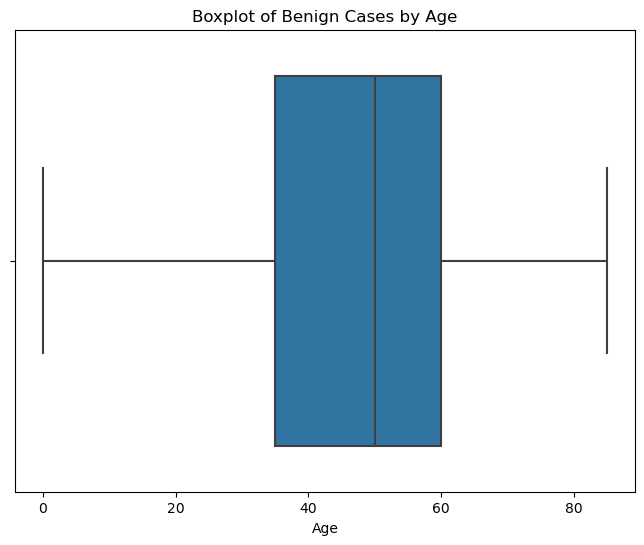

In [22]:
# Plotting boxplot for 'age'
plt.figure(figsize=(8, 6))
sns.boxplot(x='age_approx', data=benign_data)
plt.title('Boxplot of Benign Cases by Age')
plt.xlabel('Age')
plt.show()


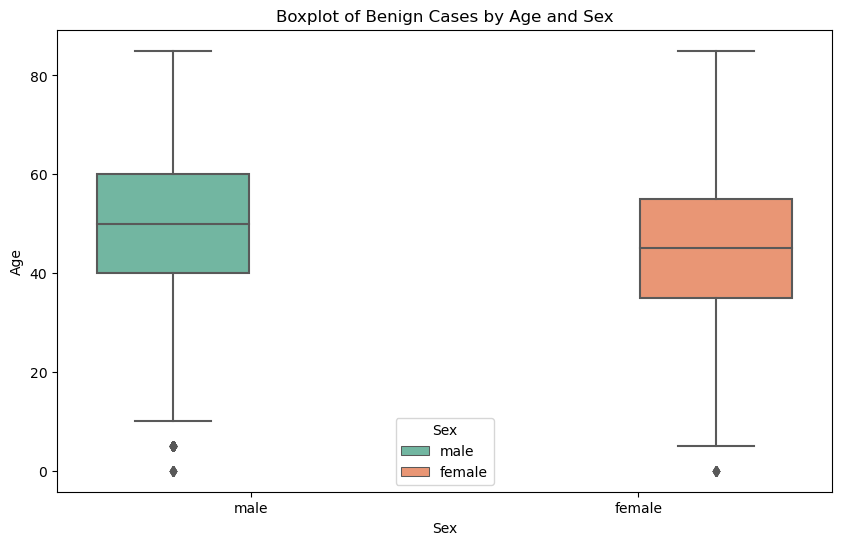

In [23]:

# Plotting separate boxplots for 'age' by 'sex'
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='age_approx', hue='sex', data=benign_data,  palette='Set2')
plt.title('Boxplot of Benign Cases by Age and Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.legend(title='Sex')
plt.show()


In [ ]:
'''The boxplot representing the number of benign cases by age and sex, it is observed that the interquartile range (IQR) for men is around 40 to 60 years old with a median of approximately 50 years. 
In women, the IQR is slightly lower, as is the median.
'''

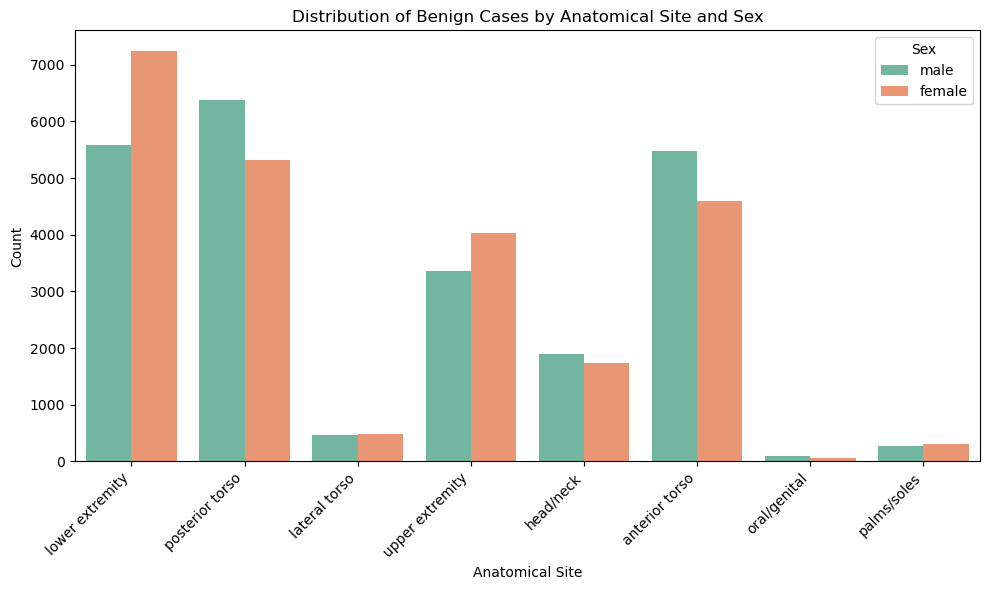

In [24]:

plt.figure(figsize=(10, 6))
sns.countplot(data=benign_data, x='anatom_site_general', hue='sex', palette='Set2')
plt.title('Distribution of Benign Cases by Anatomical Site and Sex')
plt.xlabel('Anatomical Site')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
"""
It is observed that the lower extremity is the most affected anatomical region in women, and in men, it is the posterior torso.

"""

In [25]:
benign_data.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,sex
565,ISIC_1436751,35.0,lower extremity,benign,male
566,ISIC_4728712,65.0,posterior torso,benign,female
567,ISIC_1871813,50.0,lower extremity,benign,female
568,ISIC_0541318,55.0,lower extremity,benign,male
569,ISIC_3138977,50.0,lateral torso,benign,male


In [26]:
benign_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47332 entries, 565 to 63963
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isic_id              47332 non-null  object 
 1   age_approx           47332 non-null  float64
 2   anatom_site_general  47332 non-null  object 
 3   benign_malignant     47332 non-null  object 
 4   sex                  47332 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.2+ MB


## Malignant Data

In [27]:
malignant_data = pd.read_csv ('metadata_malignant.csv')

In [28]:
malignant_data.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_5648033,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,malignant,NaN,True,contact non-polarized,...,NaN,NaN,NaN,NaN,True,NaN,NaN,756,477,NaN
1,ISIC_1435135,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,malignant,NaN,True,contact non-polarized,...,NaN,NaN,NaN,NaN,True,NaN,NaN,755,477,NaN
2,ISIC_9445977,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,malignant,NaN,True,contact non-polarized,...,NaN,NaN,NaN,NaN,True,NaN,NaN,716,477,NaN
3,ISIC_0133200,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,malignant,NaN,True,contact non-polarized,...,NaN,NaN,NaN,NaN,True,NaN,NaN,757,476,NaN
4,ISIC_7966639,"""Repeated dermoscopic images of melanocytic le...",CC-BY-NC,NaN,NaN,NaN,malignant,NaN,True,contact non-polarized,...,NaN,NaN,NaN,NaN,True,NaN,NaN,756,477,NaN


In [29]:
malignant_data.shape

(9232, 27)

In [30]:
malignant_data.dtypes

isic_id                    object
attribution                object
copyright_license          object
acquisition_day           float64
age_approx                float64
anatom_site_general        object
benign_malignant           object
clin_size_long_diam_mm    float64
concomitant_biopsy           bool
dermoscopic_type           object
diagnosis                  object
diagnosis_confirm_type     object
family_hx_mm               object
fitzpatrick_skin_type      object
image_type                 object
lesion_id                  object
mel_class                  object
mel_mitotic_index          object
mel_thick_mm              float64
mel_type                   object
mel_ulcer                  object
melanocytic                object
patient_id                 object
personal_hx_mm             object
pixels_x                    int64
pixels_y                    int64
sex                        object
dtype: object

In [31]:
malignant_data['benign_malignant'].unique()

array(['malignant'], dtype=object)

In [32]:
malignant_data['diagnosis'].unique()

array(['melanoma', nan, 'basal cell carcinoma', 'squamous cell carcinoma',
       'melanoma metastasis', 'other', 'seborrheic keratosis',
       'clear cell acanthoma'], dtype=object)

In [33]:
unmatch_malignant_data = malignant_data[(malignant_data['diagnosis'] == 'seborrheic keratosis') | 
                           (malignant_data['diagnosis'] == 'clear cell acanthoma')]


In [34]:
unmatch_malignant_data.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
6413,ISIC_0023209,Anonymous,CC-0,NaN,55.0,anterior torso,malignant,NaN,True,non-contact polarized,...,NaN,NaN,NaN,NaN,False,IP_0711919,True,640,480,male
6414,ISIC_0023208,Anonymous,CC-0,NaN,55.0,anterior torso,malignant,NaN,True,contact polarized,...,NaN,NaN,NaN,NaN,False,IP_0711919,True,3872,2592,male
6415,ISIC_0023207,Anonymous,CC-0,NaN,55.0,anterior torso,malignant,NaN,True,contact non-polarized,...,NaN,NaN,NaN,NaN,False,IP_0711919,True,3072,2304,male
7195,ISIC_0021280,Anonymous,CC-0,NaN,65.0,lower extremity,malignant,NaN,True,non-contact polarized,...,NaN,NaN,NaN,NaN,False,IP_6306913,False,3072,2304,male
7196,ISIC_0021279,Anonymous,CC-0,NaN,65.0,lower extremity,malignant,NaN,True,contact polarized,...,NaN,NaN,NaN,NaN,False,IP_6306913,False,2747,2287,male


In [35]:
unmatch_malignant_data['attribution'].unique()

array(['Anonymous'], dtype=object)

In [36]:
to_remove = unmatch_malignant_data.index

malignant_data = malignant_data.drop(to_remove)

In [37]:
malignant_data.isna().sum()

isic_id                      0
attribution                  0
copyright_license            0
acquisition_day           8850
age_approx                 330
anatom_site_general        629
benign_malignant             0
clin_size_long_diam_mm    8523
concomitant_biopsy           0
dermoscopic_type          6173
diagnosis                   45
diagnosis_confirm_type       0
family_hx_mm              7417
fitzpatrick_skin_type     8306
image_type                   0
lesion_id                 2301
mel_class                 8152
mel_mitotic_index         9160
mel_thick_mm              8479
mel_type                  9007
mel_ulcer                 9000
melanocytic                832
patient_id                5961
personal_hx_mm            7261
pixels_x                     0
pixels_y                     0
sex                        308
dtype: int64

In [38]:
#Managing NAN values

In [39]:
age_with_nan = 'age_approx'

malignant_data = malignant_data.dropna(subset=[age_with_nan])

In [40]:
sex_with_nan = 'sex'

malignant_data = malignant_data.dropna(subset=[sex_with_nan])

In [41]:
site_with_nan = 'anatom_site_general'

malignant_data = malignant_data.dropna(subset=[site_with_nan])


## Exploratory Data Analysis - Malignant Data

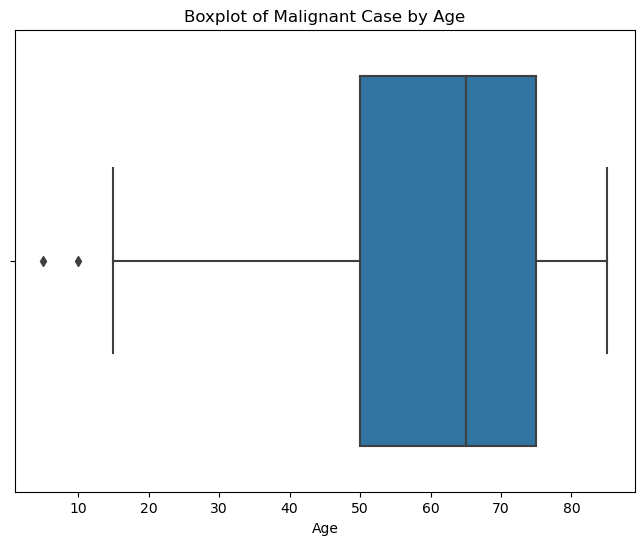

In [42]:
# Plotting boxplot for 'age'
plt.figure(figsize=(8, 6))
sns.boxplot(x='age_approx', data=malignant_data)
plt.title('Boxplot of Malignant Case by Age')
plt.xlabel('Age')
plt.show()


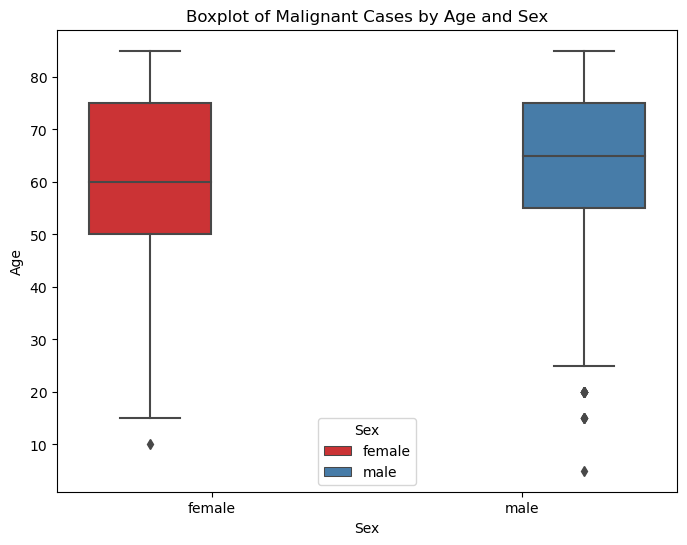

In [43]:
# Plotting separate boxplots for 'age' by 'sex'
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='age_approx', hue='sex', data=malignant_data, palette='Set1')
plt.title('Boxplot of Malignant Cases by Age and Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.legend(title='Sex')
plt.show()


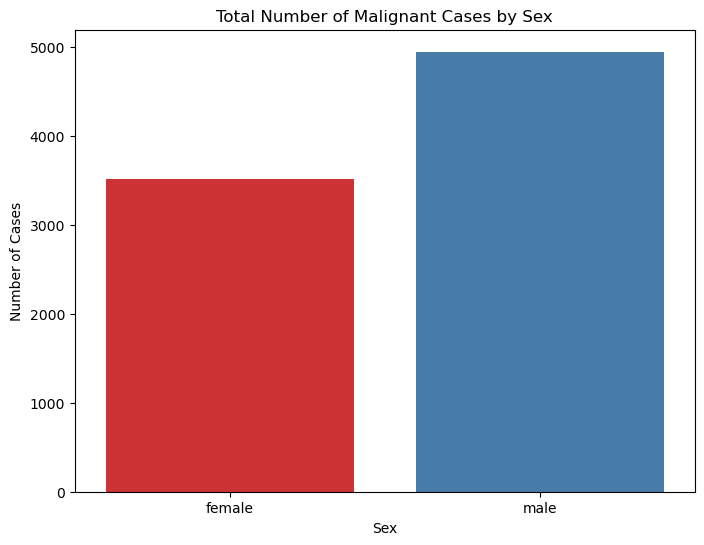

In [44]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=malignant_data, palette='Set1')
plt.title('Total Number of Malignant Cases by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Cases')
plt.show()


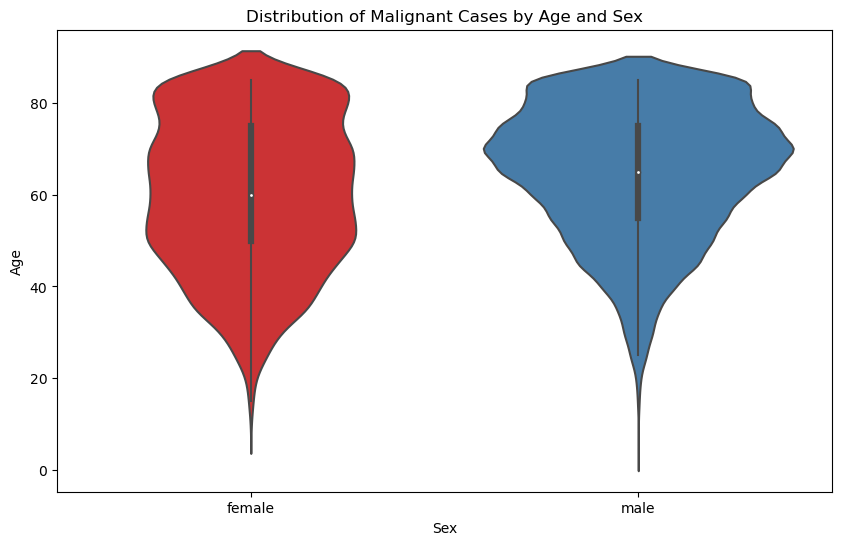

In [45]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='sex', y='age_approx', data=malignant_data, palette='Set1')
plt.title('Distribution of Malignant Cases by Age and Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()


In [ ]:
"""
Violin plots depicting malignant cases by age and sex.
We can observe that in women, the interquartile range (IQR) spans approximately from 50 years to around 75 years, with the median at around 60 years, showing a fairly consistent distribution of the number of cases throughout the IQR.
On the men's side, it's noted that the IQR occurs at a later age, around 60 years up to about 75 years, with a median age of approximately 65 years. However, there's a noticeable peak in the frequency of malignant cases at around 70 years of age.

"""

In [46]:
# Grouping the data by 'sex' and calculating quartiles for 'age'
quartiles_by_sex = malignant_data.groupby('sex')['age_approx'].quantile([0.25, 0.5, 0.75]).unstack()

# Renaming the columns for clarity
quartiles_by_sex.columns = ['Q1', 'Median', 'Q3']


quartiles_by_sex


,Q1,Median,Q3
sex,,,
female,50.0,60.0,75.0
male,55.0,65.0,75.0


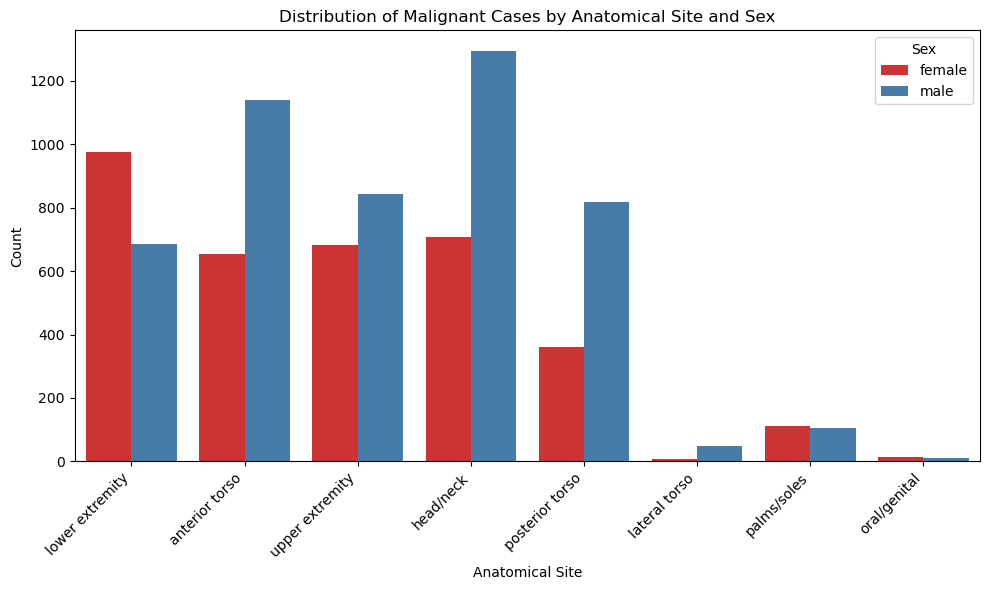

In [47]:
# Visualizing the relationship using a stacked bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=malignant_data, x='anatom_site_general', hue='sex', palette='Set1')
plt.title('Distribution of Malignant Cases by Anatomical Site and Sex')
plt.xlabel('Anatomical Site')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
"""
The anatomical location of malignant lesions, the frequency in men is notably higher in the head/neck, followed by the anterior torso. 
In women, the highest frequency of malignant lesion cases is found in the lower extremity.

"""

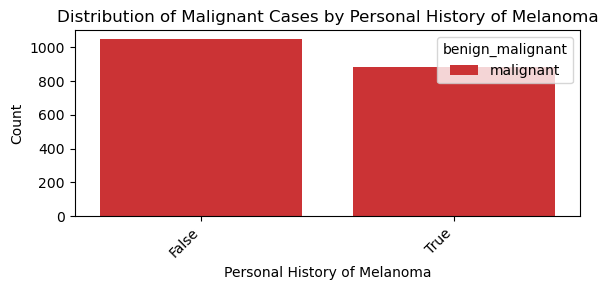

In [48]:
# Visualizing the relationship using a stacked bar plot
plt.figure(figsize=(6, 3))
sns.countplot(data=malignant_data, x='personal_hx_mm', hue='benign_malignant', palette='Set1')
plt.title('Distribution of Malignant Cases by Personal History of Melanoma')
plt.xlabel('Personal History of Melanoma')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


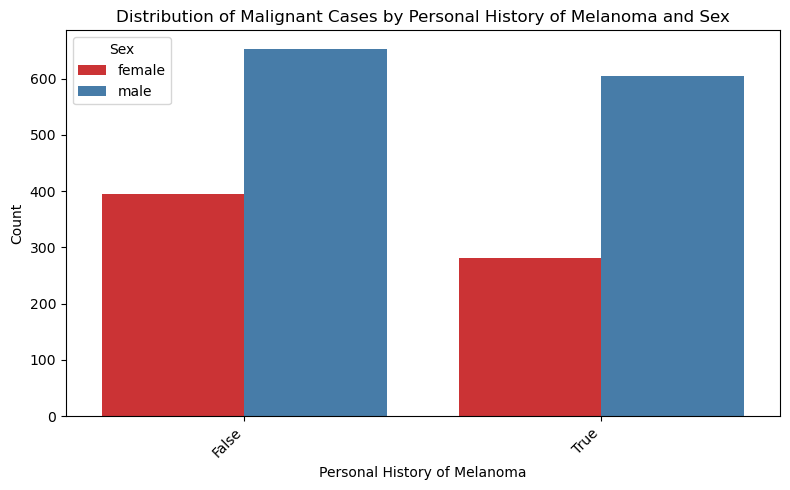

In [49]:
plt.figure(figsize=(8, 5))
sns.countplot(data=malignant_data, x='personal_hx_mm', hue='sex', palette='Set1')
plt.title('Distribution of Malignant Cases by Personal History of Melanoma and Sex')
plt.xlabel('Personal History of Melanoma')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

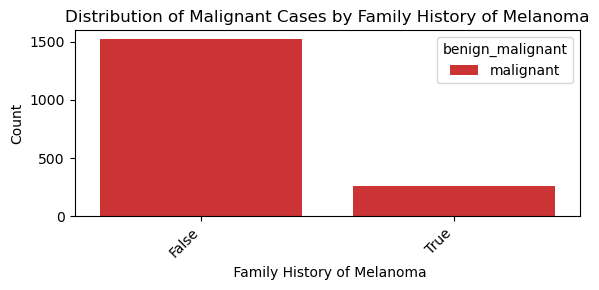

In [50]:

plt.figure(figsize=(6,3))
sns.countplot(data=malignant_data, x='family_hx_mm', hue='benign_malignant', palette='Set1')
plt.title('Distribution of Malignant Cases by Family History of Melanoma')
plt.xlabel(' Family History of Melanoma')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


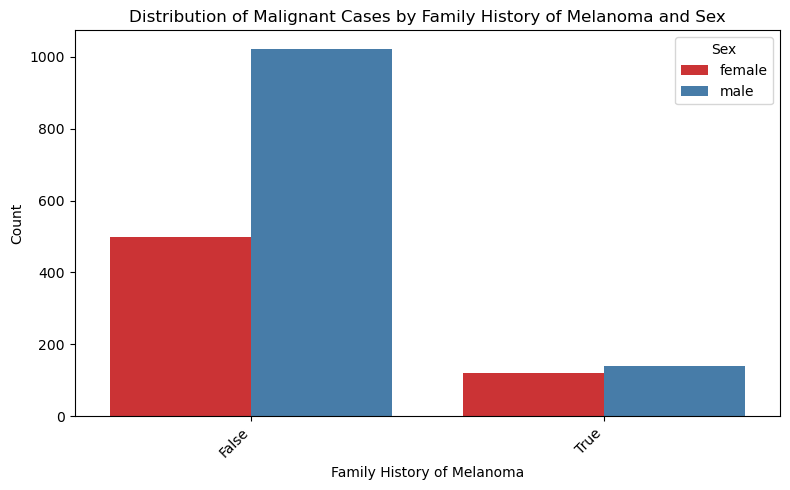

In [51]:
plt.figure(figsize=(8, 5))
sns.countplot(data=malignant_data, x='family_hx_mm', hue='sex', palette='Set1')
plt.title('Distribution of Malignant Cases by Family History of Melanoma and Sex')
plt.xlabel('Family History of Melanoma')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
"""
In these two plots representing the distribution of malignant cases by personal history and family history of melanoma, it is observed that this type of antecedent does not have an impact as a risk factor for the development of malignant lesions. 
On the contrary, what the data shows, both in men and women, is that the number of malignant cases is higher when there is no personal or family history of melanoma.
However, I need to make a caveat about these conclusions. As can be observed, only a small portion of the approximately 9k malignant entries contained information regarding a history of melanoma, which could introduce bias into this analysis.

"""

In [52]:
# Dropping the specified columns
columns_to_drop = ['melanocytic','diagnosis','attribution','copyright_license', 'acquisition_day', 'clin_size_long_diam_mm', 
                   'concomitant_biopsy', 'dermoscopic_type', 'diagnosis_confirm_type', 
                   'image_type', 'pixels_x', 'pixels_y','patient_id','lesion_id','fitzpatrick_skin_type','mel_class','mel_mitotic_index','mel_thick_mm','mel_type','mel_ulcer','family_hx_mm','personal_hx_mm']


malignant_data= malignant_data.drop(columns=columns_to_drop)

In [53]:
malignant_data.isna().sum()

isic_id                0
age_approx             0
anatom_site_general    0
benign_malignant       0
sex                    0
dtype: int64

In [54]:
malignant_data.shape

(8461, 5)

In [55]:
malignant_data.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,sex
20,ISIC_6967412,50.0,lower extremity,malignant,female
21,ISIC_6275817,40.0,anterior torso,malignant,male
22,ISIC_5561187,45.0,lower extremity,malignant,male
23,ISIC_8592733,50.0,upper extremity,malignant,male
24,ISIC_9051948,45.0,upper extremity,malignant,female


In [56]:
# Concatenate dataframes

In [57]:
skin_cancer_ai = pd.concat([malignant_data, benign_data], ignore_index=True)

In [58]:
skin_cancer_ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55793 entries, 0 to 55792
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isic_id              55793 non-null  object 
 1   age_approx           55793 non-null  float64
 2   anatom_site_general  55793 non-null  object 
 3   benign_malignant     55793 non-null  object 
 4   sex                  55793 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.1+ MB


In [59]:
# Folder with the files
images_folder = '/Users/miguelmendes/Desktop/Ironhack/Final Project/Skin_CA/Skin_Cancer_AI/'

# Get the list of files in the folder
files_in_folder = os.listdir(images_folder)

# Extract the ISIC_IDs from the files in the folder
isic_ids_in_folder = [file.split('.')[0] for file in files_in_folder]

# Compare with the ISIC_IDs in the DataFrame
isic_ids_in_dataframe = skin_cancer_ai['isic_id'].tolist()

# Find ISIC_IDs present only in the folder
isic_ids_only_in_folder = set(isic_ids_in_folder) - set(isic_ids_in_dataframe)

# Find ISIC_IDs present only in the DataFrame
isic_ids_only_in_dataframe = set(isic_ids_in_dataframe) - set(isic_ids_in_folder)

# Print the results
print("ISIC_IDs present only in the folder:")
for isic_id in isic_ids_only_in_folder:
    print(isic_id)

print("\nISIC_IDs present only in the DataFrame:")
for isic_id in isic_ids_only_in_dataframe:
    print(isic_id)




ISIC_IDs present only in the folder:


ISIC_IDs present only in the DataFrame:
ISIC_0021707
ISIC_0015517
ISIC_1000616
ISIC_4514316
ISIC_0014424
ISIC_0070588
ISIC_0023464
ISIC_0061244
ISIC_2444283
ISIC_0015576
ISIC_0064606
ISIC_3867890
ISIC_0022565
ISIC_0011711
ISIC_0011648
ISIC_0014160
ISIC_0015332
ISIC_0015124
ISIC_0022999
ISIC_0072824
ISIC_0057141
ISIC_0063792
ISIC_0013699
ISIC_5667461
ISIC_9199429
ISIC_7660163
ISIC_0013444
ISIC_0023589
ISIC_0014719
ISIC_0067831
ISIC_0021983
ISIC_7338073
ISIC_8540289
ISIC_0014695
ISIC_7453676
ISIC_2823287
ISIC_0013232
ISIC_0022956
ISIC_0013822
ISIC_0013411
ISIC_1440985
ISIC_0028847
ISIC_0015121
ISIC_0012081
ISIC_0014181
ISIC_0014953
ISIC_0014239
ISIC_0388469
ISIC_0024033
ISIC_6604083
ISIC_0962121
ISIC_0022332
ISIC_0070794
ISIC_8133350
ISIC_0010782
ISIC_0015163
ISIC_0032207
ISIC_0014347
ISIC_5343231
ISIC_8692218
ISIC_0012781
ISIC_0000276
ISIC_4810142
ISIC_7939816
ISIC_0014871
ISIC_0070198
ISIC_7993345
ISIC_0023276
ISIC_3271069
ISIC_0014809
ISIC_302364

In [60]:
# Folder with the files
images_folder = '/Users/miguelmendes/Desktop/Ironhack/Final Project/Skin_CA/Skin_Cancer_AI/'

# Delete files corresponding to ISIC_IDs in the set
for isic_id in isic_ids_only_in_folder:
    file_path = os.path.join(images_folder, isic_id + '.JPG')
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"File '{isic_id}.JPG' deleted successfully.")
    else:
        print(f"File '{isic_id}.JPG' not found.")


File '.JPG' not found.


In [61]:
# Convert the set to a list
isic_ids_only_in_dataframe_list = list(isic_ids_only_in_dataframe)

# Filter out rows with ISIC_IDs present in isic_ids_only_in_dataframe_list
skin_cancer_ai = skin_cancer_ai[~skin_cancer_ai['isic_id'].isin(isic_ids_only_in_dataframe_list)]

skin_cancer_ai


,isic_id,age_approx,anatom_site_general,benign_malignant,sex
0,ISIC_6967412,50.0,lower extremity,malignant,female
1,ISIC_6275817,40.0,anterior torso,malignant,male
3,ISIC_8592733,50.0,upper extremity,malignant,male
4,ISIC_9051948,45.0,upper extremity,malignant,female
5,ISIC_7927389,40.0,lower extremity,malignant,female
...,...,...,...,...,...
55788,ISIC_0000006,25.0,posterior torso,benign,female
55789,ISIC_0000005,40.0,anterior torso,benign,female
55790,ISIC_0000003,30.0,upper extremity,benign,male
55791,ISIC_0000001,30.0,anterior torso,benign,female


In [62]:
skin_cancer_ai = skin_cancer_ai.rename(columns={'age_approx': 'age', 'anatom_site_general': 'anatomical_site','benign_malignant':'lesion_type'})

In [63]:
skin_cancer_ai.dtypes

isic_id             object
age                float64
anatomical_site     object
lesion_type         object
sex                 object
dtype: object

In [64]:
skin_cancer_ai.to_csv('SkinCancerAI.csv', index=False)

# Model

In [65]:
skin_cancer_ai

,isic_id,age,anatomical_site,lesion_type,sex
0,ISIC_6967412,50.0,lower extremity,malignant,female
1,ISIC_6275817,40.0,anterior torso,malignant,male
3,ISIC_8592733,50.0,upper extremity,malignant,male
4,ISIC_9051948,45.0,upper extremity,malignant,female
5,ISIC_7927389,40.0,lower extremity,malignant,female
...,...,...,...,...,...
55788,ISIC_0000006,25.0,posterior torso,benign,female
55789,ISIC_0000005,40.0,anterior torso,benign,female
55790,ISIC_0000003,30.0,upper extremity,benign,male
55791,ISIC_0000001,30.0,anterior torso,benign,female


In [66]:
# List of categorical columns to encode
categorical_columns = ['lesion_type','anatomical_site','sex']

# Encode the categorical columns
skin_cancer_ai_encoded = pd.get_dummies(skin_cancer_ai, columns=categorical_columns)


In [67]:
# Directory containing the images
images_directory = '/Users/miguelmendes/Desktop/Ironhack/Final Project/Skin_CA/Skin_Cancer_AI/'

# Assuming you have a DataFrame named skin_cancer_ai_encoded
# Add a column with the full path of the images to the DataFrame
skin_cancer_ai_encoded['image_path'] = skin_cancer_ai_encoded['isic_id'].apply(lambda x: os.path.join(images_directory, x + '.JPG'))

In [88]:
skin_cancer_ai_encoded

,isic_id,age,lesion_type_benign,lesion_type_malignant,anatomical_site_anterior torso,anatomical_site_head/neck,anatomical_site_lateral torso,anatomical_site_lower extremity,anatomical_site_oral/genital,anatomical_site_palms/soles,anatomical_site_posterior torso,anatomical_site_upper extremity,sex_female,sex_male,image_path
0,ISIC_6967412,50.0,False,True,False,False,False,True,False,False,False,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
1,ISIC_6275817,40.0,False,True,True,False,False,False,False,False,False,False,False,True,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
3,ISIC_8592733,50.0,False,True,False,False,False,False,False,False,False,True,False,True,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
4,ISIC_9051948,45.0,False,True,False,False,False,False,False,False,False,True,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
5,ISIC_7927389,40.0,False,True,False,False,False,True,False,False,False,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55788,ISIC_0000006,25.0,True,False,False,False,False,False,False,False,True,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
55789,ISIC_0000005,40.0,True,False,True,False,False,False,False,False,False,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
55790,ISIC_0000003,30.0,True,False,False,False,False,False,False,False,False,True,False,True,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
55791,ISIC_0000001,30.0,True,False,True,False,False,False,False,False,False,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...


In [89]:
data_oversampling= skin_cancer_ai_encoded.copy()

In [90]:
data_oversampling.head()

,isic_id,age,lesion_type_benign,lesion_type_malignant,anatomical_site_anterior torso,anatomical_site_head/neck,anatomical_site_lateral torso,anatomical_site_lower extremity,anatomical_site_oral/genital,anatomical_site_palms/soles,anatomical_site_posterior torso,anatomical_site_upper extremity,sex_female,sex_male,image_path
0,ISIC_6967412,50.0,False,True,False,False,False,True,False,False,False,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
1,ISIC_6275817,40.0,False,True,True,False,False,False,False,False,False,False,False,True,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
3,ISIC_8592733,50.0,False,True,False,False,False,False,False,False,False,True,False,True,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
4,ISIC_9051948,45.0,False,True,False,False,False,False,False,False,False,True,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...
5,ISIC_7927389,40.0,False,True,False,False,False,True,False,False,False,False,True,False,/Users/miguelmendes/Desktop/Ironhack/Final Pro...


# Image Preprocessing

In [77]:
# Define the function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(75, 75))  
    img_array = img_to_array(img) / 255.0  
    return img_array

# Apply the function to the 'image_path' column to load and preprocess images
data_oversampling['image'] = data_oversampling['image_path'].apply(load_and_preprocess_image)

In [78]:
# Convert specific columns to integer type
data_oversampling['age'] = data_oversampling['age'].astype(int)
data_oversampling['lesion_type_benign'] = data_oversampling['lesion_type_benign'].astype(int)
data_oversampling['lesion_type_malignant'] = data_oversampling['lesion_type_malignant'].astype(int)
data_oversampling['anatomical_site_anterior torso'] = data_oversampling['anatomical_site_anterior torso'].astype(int)
data_oversampling['anatomical_site_head/neck'] = data_oversampling['anatomical_site_head/neck'].astype(int)
data_oversampling['anatomical_site_lateral torso'] = data_oversampling['anatomical_site_lateral torso'].astype(int)
data_oversampling['anatomical_site_lower extremity'] = data_oversampling['anatomical_site_lower extremity'].astype(int)
data_oversampling['anatomical_site_oral/genital'] = data_oversampling['anatomical_site_oral/genital'].astype(int)
data_oversampling['anatomical_site_palms/soles'] = data_oversampling['anatomical_site_palms/soles'].astype(int)
data_oversampling['anatomical_site_posterior torso'] = data_oversampling['anatomical_site_posterior torso'].astype(int)
data_oversampling['anatomical_site_upper extremity'] = data_oversampling['anatomical_site_upper extremity'].astype(int)
data_oversampling['sex_female'] = data_oversampling['sex_female'].astype(int)
data_oversampling['sex_male'] = data_oversampling['sex_male'].astype(int)


In [79]:
#Saving df with pickle
data_oversampling.to_pickle('data_oversampling75.pkl')

In [93]:
# Open the pickle file in read-binary mode
with open('data_oversampling75.pkl', 'rb') as f:
    # Load the data from the pickle file
    data_oversampling = pickle.load(f)

data_oversampling.head()

,isic_id,age,lesion_type_benign,lesion_type_malignant,anatomical_site_anterior torso,anatomical_site_head/neck,anatomical_site_lateral torso,anatomical_site_lower extremity,anatomical_site_oral/genital,anatomical_site_palms/soles,anatomical_site_posterior torso,anatomical_site_upper extremity,sex_female,sex_male,image_path,image
0,ISIC_6967412,50,0,1,0,0,0,1,0,0,0,0,1,0,/Users/miguelmendes/Desktop/Ironhack/Final Pro...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
1,ISIC_6275817,40,0,1,1,0,0,0,0,0,0,0,0,1,/Users/miguelmendes/Desktop/Ironhack/Final Pro...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
3,ISIC_8592733,50,0,1,0,0,0,0,0,0,0,1,0,1,/Users/miguelmendes/Desktop/Ironhack/Final Pro...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
4,ISIC_9051948,45,0,1,0,0,0,0,0,0,0,1,1,0,/Users/miguelmendes/Desktop/Ironhack/Final Pro...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
5,ISIC_7927389,40,0,1,0,0,0,1,0,0,0,0,1,0,/Users/miguelmendes/Desktop/Ironhack/Final Pro...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."


In [94]:
X_img = np.stack(data_oversampling['image'].values)
X_tab = data_oversampling[['age','anatomical_site_anterior torso', 'anatomical_site_head/neck', 'anatomical_site_lateral torso', 'anatomical_site_lower extremity', 'anatomical_site_oral/genital', 'anatomical_site_palms/soles', 'anatomical_site_posterior torso', 'anatomical_site_upper extremity', 'sex_female', 'sex_male']].astype(int)
y = data_oversampling['lesion_type_malignant']

In [95]:
#Splitting the data into training and testing sets
X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(X_img, X_tab, y, test_size=0.2, random_state=42)

In [ ]:
# Oversampling
#Apply SMOTE to the minority class (malignant) for the training data of images.
smote_img = SMOTE(sampling_strategy='minority', random_state=42)
num_samples_img, height, width, channels = X_img_train.shape
X_img_train_reshaped = X_img_train.reshape((num_samples_img, height * width * channels))
X_img_train_resampled, y_train_resampled_img = smote_img.fit_resample(X_img_train_reshaped, y_train)

#Apply SMOTE to the minority class (malignant) for the tabular training data.
smote_tab = SMOTE(sampling_strategy='minority', random_state=42)
X_tab_train_resampled, y_train_resampled_tab = smote_tab.fit_resample(X_tab_train, y_train)




In [ ]:
def plot_training(hist):
    '''
    This function takes training model and plots history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    index_acc = np.argmax(val_acc)
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, tr_loss[index_loss], s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , tr_acc[index_acc], s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred):
    """
    Plots the confusion matrix.

    Args:
    - y_true: true labels
    - y_pred: predicted labels
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred):
    """
    Plots the ROC curve.

    Args:
    - y_true: true labels
    - y_pred: predicted probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()




In [ ]:
# Reshape image data to the original shape
X_img_train_resampled_original_shape = X_img_train_resampled.reshape((-1, 75, 75, 3))

# Adjust model inputs
img_input = Input(shape=(75, 75, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Adding one more convolutional layer
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)  # Dropout for regularization

# Densely connected layer for tabular data
tab_input = Input(shape=(X_tab_train_resampled.shape[1],))
y_oversamp = Dense(128, activation='relu')(tab_input)

# Concatenating outputs
combined = concatenate([x, y_oversamp])

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Creating the model
model = Model(inputs=[img_input, tab_input], outputs=output)

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with oversampled data
train = model.fit([X_img_train_resampled_original_shape, X_tab_train_resampled], y_train_resampled_img, epochs=100, batch_size=32, validation_split=0.2)

# Evaluating the model
loss, accuracy = model.evaluate([X_img_test, X_tab_test], y_test)
print("Test Accuracy:", accuracy)

# Making predictions with the model
predictions = model.predict([X_img_test, X_tab_test])

# Converting probabilities into binary classes
y_pred_classes = (predictions > 0.5).astype(int)

# Printing the classification report
print(classification_report(y_test, y_pred_classes))

plot_confusion_matrix(y_test, y_pred_classes)
plot_roc_curve(y_test, predictions)
plot_training(train)

# Saving the model
model.save('skin_cancer_oversampling_model.keras')


## Model with image-only input for use in the app


In [ ]:
# Reshape image data to the original shape
X_img_train_resampled_original_shape = X_img_train_resampled.reshape((-1, 75, 75, 3))

# Adjust model inputs
img_input = Input(shape=(75, 75, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Adding one more convolutional layer
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)  # Dropout for regularization

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Creating the model
model = Model(inputs=img_input, outputs=output)

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with oversampled data
train = model.fit(X_img_train_resampled_original_shape, y_train_resampled_img, epochs=80, batch_size=32, validation_split=0.25)

# Evaluating the model
loss, accuracy = model.evaluate(X_img_test, y_test)
print("Test Accuracy:", accuracy)

# Making predictions with the model
predictions = model.predict(X_img_test)

# Calculating the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Converting probabilities into binary classes
y_pred_classes = (predictions > 0.5).astype(int)

# Printing the classification report
print(classification_report(y_test, y_pred_classes))

plot_confusion_matrix(y_test, y_pred_classes)
plot_roc_curve(y_test, predictions)
plot_training(train)

# Saving the model
model.save('skin_cancer_image_only_model.keras')


